# Install dependencies
These are required to use fifty one.

In [ ]:
!pip install -U Jinja2

!pip install opencv-python-headless==4.1.2.30

!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 12.5 MB/s 
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 12.4 MB/s 
     |██████████

In [ ]:
# Load the drive to access the images and annotations
from google.colab import drive
drive.mount('/content/gdrive')

# reduce the path of the drive
def driveSymboLink():
  # this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
  !ln -s /content/gdrive/My\ Drive/ /mydrive
  # !ls /mydrive

driveSymboLink()

Mounted at /content/gdrive


In [ ]:
# Add the path of the repo to locate utils
import sys
sys.path.append('/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/')

# Import libraries
import fiftyone as fo
import os
import numpy as np
import shutil
# from utils.utils import create_yolov4_dataset
from utils.utils import create_yolov5_dataset
from utils.utils import split_dev_test
# import utils as utl

# Other libraries
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


NumExpr defaulting to 2 threads.
Migrating database to v0.16.2


Let's load the json file to get some info

In [ ]:
f = open("/content/gdrive/MyDrive/MIDS/W210/leopard.coco/annotations/instances_train2022.json")

data = json.load(f)



In [ ]:
print(f"Total annotations: {len(data['annotations'])}")

Total annotations: 6825


## Create a dataframe
We must create two tables for annotations and image data, then we will join them.

In [ ]:
dfA=pd.DataFrame(data['annotations'])
dfImg=pd.DataFrame(data['images'])
dfCat=pd.DataFrame(data['categories'])
df = dfA.merge(dfImg, on='id', how='left')
df.head()

,bbox,theta,viewpoint,segmentation,segmentation_bbox,area,iscrowd,id,image_id,category_id,...,file_name,photographer,coco_url,height,width,date_captured,gps_lat_captured,gps_lon_captured,flickr_url,uuid_y
0,"[163.02083333333334, 411.9791666666667, 2161.4...",0.0,front,"[[163, 412, 2324, 412, 2324, 1649, 163, 1649, ...","[163, 412, 2161, 1237]",2673157,0,1,1,0,...,000000000001.jpg,,None,1800.0,2400.0,None,None,None,None,2fcbcdb2-1683-77b4-0b41-b6a2edd56189
1,"[448.43750000000006, 301.0416666666667, 1794.2...",0.0,front,"[[448, 301, 2243, 301, 2243, 1389, 448, 1389, ...","[448, 301, 1795, 1088]",1952960,0,2,2,0,...,000000000002.jpg,,None,1800.0,2400.0,None,None,None,None,327506d7-98c5-3261-3266-aba10b0615c8
2,"[476.0416666666667, 628.6458333333334, 1743.75...",0.0,front,"[[476, 629, 2220, 629, 2220, 1755, 476, 1755, ...","[476, 629, 1744, 1126]",1963744,0,3,3,0,...,000000000003.jpg,,None,1800.0,2400.0,None,None,None,None,a4b978c8-9949-5804-e3c1-ebe8bc7637ea
3,"[206.77083333333334, 255.20833333333334, 2193....",0.0,front,"[[207, 255, 2400, 255, 2400, 1660, 207, 1660, ...","[207, 255, 2192, 1405]",3079760,0,4,4,0,...,000000000004.jpg,,None,1800.0,2400.0,None,None,None,None,c6f35b63-c6c2-d93c-6906-3ae895d0afce
4,"[296.3541666666667, 633.8541666666667, 1947.91...",0.0,back,"[[296, 634, 2244, 634, 2244, 1593, 296, 1593, ...","[296, 634, 1948, 959]",1868132,0,5,5,0,...,000000000005.jpg,,None,1800.0,2400.0,None,None,None,None,f2e2c56e-8574-b294-4500-438f3cbe0b7f


## Missing data


In [ ]:
df.describe()

,theta,area,iscrowd,id,image_id,category_id,isinterest,license,height,width
count,6825.0,6.825000e+03,6825.0,6825.000000,6825.000000,6825.0,6825.0,6795.0,6795.000000,6795.00000
mean,0.0,1.089760e+06,0.0,3413.000000,3403.054799,0.0,0.0,3.0,1659.037675,2389.24312
std,0.0,1.082309e+06,0.0,1970.352126,1964.406726,0.0,0.0,0.0,232.864266,96.52857
min,0.0,1.027200e+04,0.0,1.000000,1.000000,0.0,0.0,3.0,741.000000,761.00000
25%,0.0,3.277620e+05,0.0,1707.000000,1703.000000,0.0,0.0,3.0,1399.500000,2400.00000
50%,0.0,6.460000e+05,0.0,3413.000000,3400.000000,0.0,0.0,3.0,1800.000000,2400.00000
75%,0.0,1.514739e+06,0.0,5119.000000,5105.000000,0.0,0.0,3.0,1800.000000,2400.00000
max,0.0,5.365900e+06,0.0,6825.000000,6795.000000,0.0,0.0,3.0,2400.000000,2400.00000


In [ ]:
df.describe(include="all")

,bbox,theta,viewpoint,segmentation,segmentation_bbox,area,iscrowd,id,image_id,category_id,...,file_name,photographer,coco_url,height,width,date_captured,gps_lat_captured,gps_lon_captured,flickr_url,uuid_y
count,6825,6825.0,6647,6825,6825,6.825000e+03,6825.0,6825.000000,6825.000000,6825.0,...,6795,6795,0,6795.000000,6795.00000,0,0,0,0,6795
unique,6822,NaN,5,6819,6819,NaN,NaN,NaN,NaN,NaN,...,6795,1,0,NaN,NaN,0,0,0,0,6795
top,"[132.71604938271605, 602.469135802469, 2059.87...",NaN,left,"[[133, 602, 2193, 602, 2193, 1583, 133, 1583, ...","[133, 602, 2060, 981]",NaN,NaN,NaN,NaN,NaN,...,000000000001.jpg,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2fcbcdb2-1683-77b4-0b41-b6a2edd56189
freq,2,NaN,2283,2,2,NaN,NaN,NaN,NaN,NaN,...,1,6795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,0.0,NaN,NaN,NaN,1.089760e+06,0.0,3413.000000,3403.054799,0.0,...,NaN,NaN,NaN,1659.037675,2389.24312,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,1.082309e+06,0.0,1970.352126,1964.406726,0.0,...,NaN,NaN,NaN,232.864266,96.52857,NaN,NaN,NaN,NaN,NaN
min,NaN,0.0,NaN,NaN,NaN,1.027200e+04,0.0,1.000000,1.000000,0.0,...,NaN,NaN,NaN,741.000000,761.00000,NaN,NaN,NaN,NaN,NaN
25%,NaN,0.0,NaN,NaN,NaN,3.277620e+05,0.0,1707.000000,1703.000000,0.0,...,NaN,NaN,NaN,1399.500000,2400.00000,NaN,NaN,NaN,NaN,NaN
50%,NaN,0.0,NaN,NaN,NaN,6.460000e+05,0.0,3413.000000,3400.000000,0.0,...,NaN,NaN,NaN,1800.000000,2400.00000,NaN,NaN,NaN,NaN,NaN
75%,NaN,0.0,NaN,NaN,NaN,1.514739e+06,0.0,5119.000000,5105.000000,0.0,...,NaN,NaN,NaN,1800.000000,2400.00000,NaN,NaN,NaN,NaN,NaN


# How many different individual leopards are in the images?
We know that the name is a unique identifier, so by checking how many times is repeated in the annotations we can deduct the total number of leopards.

In [ ]:
individuals={}
leopards=0
for record in data['annotations']:
  if record['name'] not in individuals:
    # print("Adding name")
    individuals.update(
        {record['name']:{
        'count':0, 
        'left':0, 
        'right':0, 
        'front':0, 
        'back':0, 
        'none':0,
        'down':0}
        })
    leopards+=1
  individuals[record['name']]['count'] +=1

  if record['viewpoint']==None:
     individuals[record['name']]['none'] +=1
  else:
     individuals[record['name']][record['viewpoint']] +=1

print(individuals)
print(leopards)

{'9ec659d2-2183-4f55-8882-1fe87e13d5f4': {'count': 298, 'left': 62, 'right': 80, 'front': 77, 'back': 57, 'none': 8, 'down': 14}, 'e19c3dc4-0122-4c0a-be99-fbdb3e4741ef': {'count': 120, 'left': 48, 'right': 37, 'front': 9, 'back': 13, 'none': 8, 'down': 5}, 'b29befd8-9bbb-4306-aacc-01ed8573810a': {'count': 4, 'left': 3, 'right': 1, 'front': 0, 'back': 0, 'none': 0, 'down': 0}, '2039c9dc-9b2d-41c0-9ffd-4bd5297813ed': {'count': 48, 'left': 11, 'right': 17, 'front': 11, 'back': 6, 'none': 0, 'down': 3}, 'ad886592-f2e1-4a83-84dd-aa9ca3b8763c': {'count': 40, 'left': 12, 'right': 15, 'front': 0, 'back': 13, 'none': 0, 'down': 0}, '39643a79-975c-45eb-9ca0-3cb835fa9145': {'count': 12, 'left': 8, 'right': 1, 'front': 2, 'back': 1, 'none': 0, 'down': 0}, 'f9fd85b1-e3bb-45a3-9cb4-06f0c04ec8c2': {'count': 9, 'left': 0, 'right': 5, 'front': 4, 'back': 0, 'none': 0, 'down': 0}, '1eec726a-99dd-403e-9cbb-aa4428fa3cf6': {'count': 43, 'left': 6, 'right': 24, 'front': 1, 'back': 8, 'none': 0, 'down': 4}, 

Text(0, 0.5, 'count of individuals')

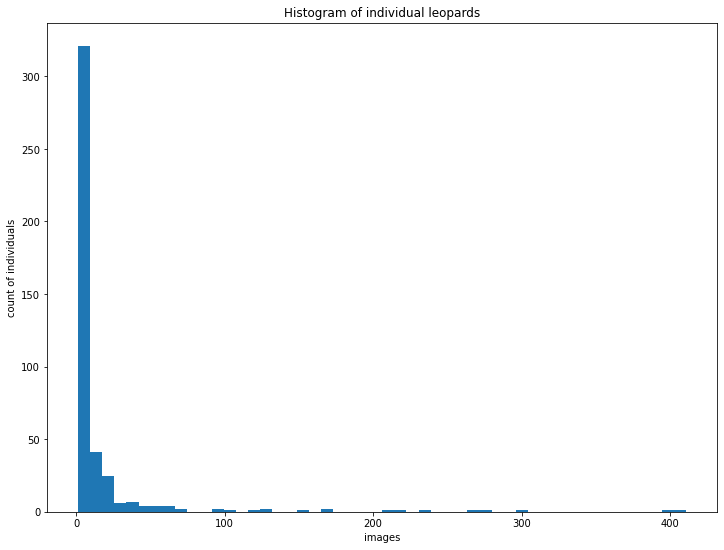

In [ ]:
# Get individual leopard counts
lep_count=[individuals[leopard]['count'] for leopard in dict(list(individuals.items()))]

# Plot the histogram of images per individual leopard
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 9, forward=True)
ax.hist(lep_count, bins=50)
ax.set_title("Histogram of individual leopards")
ax.set_xlabel("images")
ax.set_ylabel("count of individuals")

## How balanced are the images based on the viewpoint?
We are trying to identify leopards based on their spots. We know that the pattern differ based on the flank or other body parts. For this reason, having a balanced set of orientations would help the model identify a specific leopard.

In [ ]:
# Get all the viewpoints given an individual leopard
lep_left=[individuals[leopard]['left'] for leopard in dict(list(individuals.items()))]
lep_right=[individuals[leopard]['right'] for leopard in dict(list(individuals.items()))]
lep_front=[individuals[leopard]['front'] for leopard in dict(list(individuals.items()))]
lep_back=[individuals[leopard]['back'] for leopard in dict(list(individuals.items()))]
lep_down=[individuals[leopard]['down'] for leopard in dict(list(individuals.items()))]
lep_none=[individuals[leopard]['none'] for leopard in dict(list(individuals.items()))]

totalImgByView=[sum(lep_left), sum(lep_right),sum(lep_front),sum(lep_back),sum(lep_down),sum(lep_none)]

viewnames=['Left', 'Right', 'Front', 'Back', 'Down', "None"]

Text(0, 0.5, 'count of images')

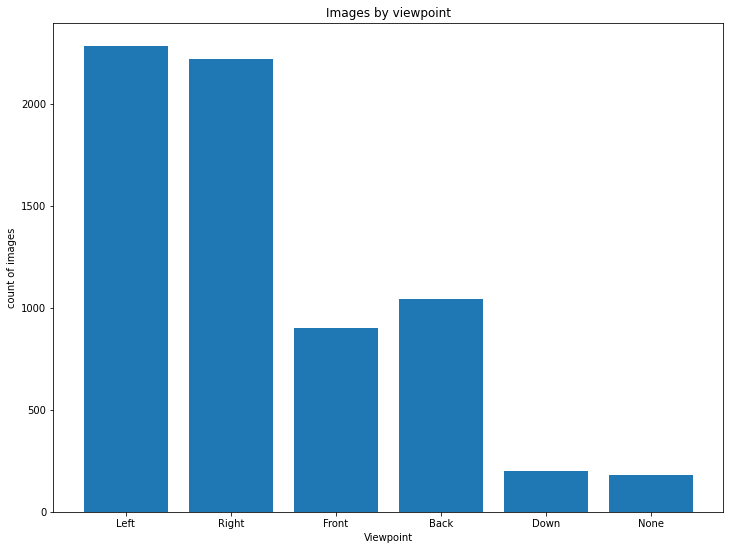

In [ ]:
# plot the viewpoints
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 9, forward=True)
ax.bar(x=viewnames,height=totalImgByView)
ax.set_title("Images by viewpoint")
ax.set_xlabel("Viewpoint")
ax.set_ylabel("count of images")

## How imbalanced are the viewpoints by individual leopard?
Now we're plotting the viewpoints given each of the 431 individual leopards.

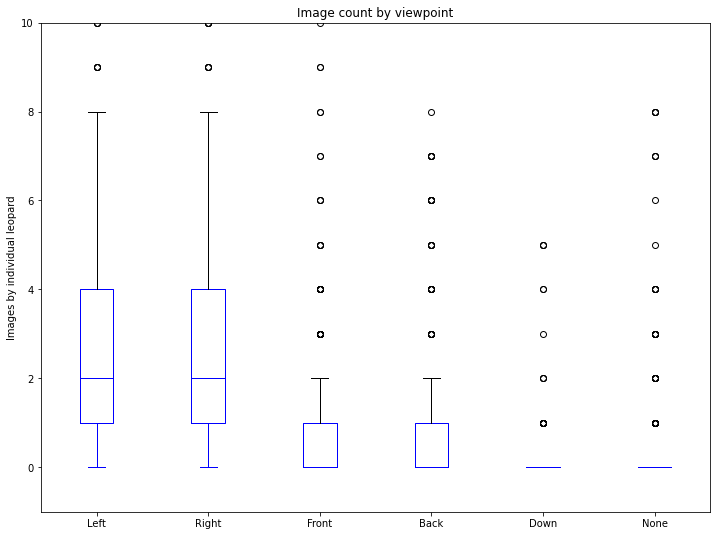

In [ ]:
# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='blue')
    plt.setp(bp['caps'][0], color='blue')
    plt.setp(bp['whiskers'][0], color='blue')
    plt.setp(bp['fliers'][0], color='blue')
    plt.setp(bp['medians'][0], color='blue')

# Some fake data to plot
A = lep_left
B = lep_right
C = lep_front
D = lep_back
E = lep_down
F = lep_none

fig = plt.figure()
fig.set_size_inches(12, 9, forward=True)
ax = plt.axes()
# hold(True)

# first boxplot pair
bp = plt.boxplot(A
             , positions = [1]
             , widths = 0.6)
setBoxColors(bp)

# second boxplot pair
bp = plt.boxplot(B
             , positions = [3]
             , widths = 0.6)
setBoxColors(bp)

# thrid boxplot pair
bp = plt.boxplot(C
             , positions = [5]
             , widths = 0.6)
setBoxColors(bp)

# fourth boxplot pair
bp = plt.boxplot(D
             , positions = [7]
             , widths = 0.6)
setBoxColors(bp)

# fifth boxplot pair
bp = plt.boxplot(E
             , positions = [9]
             , widths = 0.6)
setBoxColors(bp)

# Sixth boxplot pair
bp = plt.boxplot(F
             , positions = [11]
             , widths = 0.6)
setBoxColors(bp)

# set axes limits and labels
ax.set_xlim(0,12)
ax.set_ylim(-1,10)
ax.set_xticklabels(viewnames)
ax.set_xticks([1,3,5,7,9,11])
ax.set_ylabel("Images by individual leopard")

plt.title("Image count by viewpoint")
plt.show()

We can see how most of the leopards have between two to four images from the left and right flank. While images from the front and back are scarce. About 25% of the individuals have only one from the front and back. There are some rare images with images from down. We also have some outlier classes which we would need to undersample.

# What is the image size distribution?

In [ ]:
missingFields=['theta','iscrowd','category_id','isinterest','license']
df=df.drop(missingFields,axis=1)

Text(0.5, 0.98, 'Aspect ratio distribution')

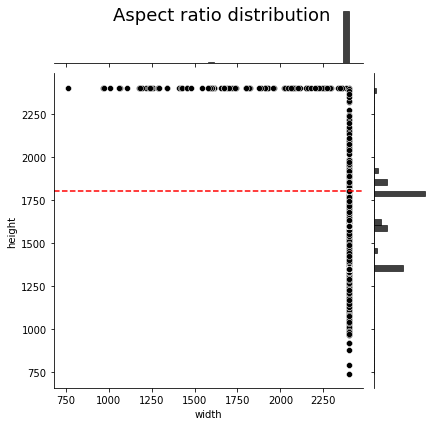

In [ ]:
aRatioPlot=sns.jointplot(x="width", y="height"
              , data=df
              , color="k"
              # , kind="reg"
              , marginal_kws=dict(bins=50))
aRatioPlot.ax_joint.axhline(y=df.height.median()
                           ,linestyle='--'
                           , color='red')
plt.xlabel("width", size=16)
plt.ylabel("height", size=16)
aRatioPlot.fig.suptitle("Aspect ratio distribution", size=18)


In [ ]:
tallImg=df[df.height/df.width<=0.5]['id'].count()
tallImg

103

## How many 4:3 aspect ratio images?

In [ ]:
regImg=df[(df.height/df.width>=0.74) & (df.height/df.width<=.76)]['id'].count()
regImg

2632

## How many square images are in the dataset?

In [ ]:
sqImg=df[(df.height/df.width>=0.99) & (df.height/df.width<=1.01)]['id'].count()
sqImg

4

## How many wide images are in the dataset?

In [ ]:
wImg=df[(df.height/df.width>=1.9) & (df.height/df.width<=2.01)]['id'].count()
wImg

5

## How many extra wide images?


In [ ]:
ewImg=df[df.height/df.width>=2]['id'].count()
ewImg

10

Most of the images are 2400 x 1800 px. Abouth 1,500 (22%) of the images are extra wide 2400 x 1500 px. There very few square ones

Text(0.5, 1.0, 'Height distribution')

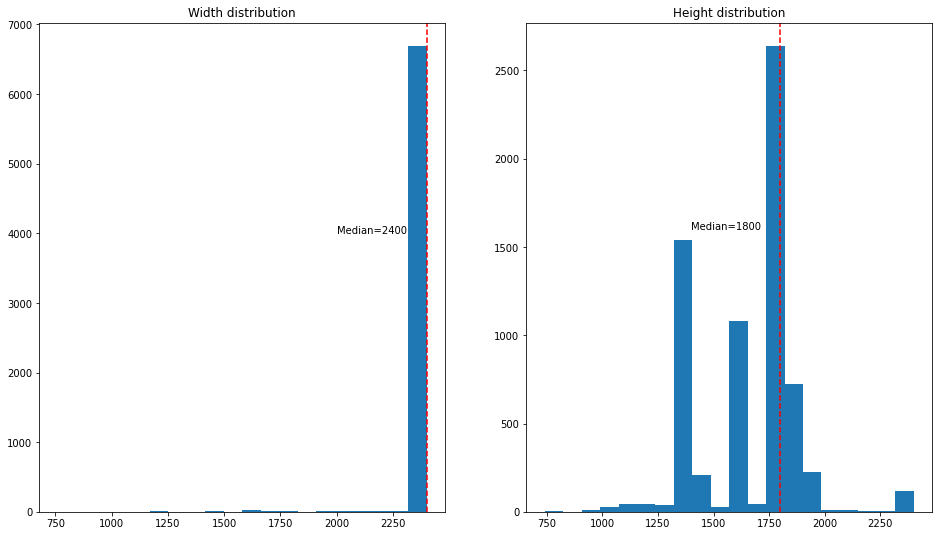

In [ ]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(16, 9, forward=True)

ax[0].hist(df.width, bins=20)
ax[0].axvline(df.width.median(), color='red',linestyle='--')
ax[0].text(df.width.median()-400, 4000, f'Median={int(df.width.median())}')
ax[0].set_title("Width distribution")
ax[1].hist(df.height, bins=20)
ax[1].axvline(df.height.median(), color='red',linestyle='--')
ax[1].text(df.height.median()-400, 1600, f'Median={int(df.height.median())}')
ax[1].set_title("Height distribution")

# What is the aspect ratio distribution?

Text(0.5, 1.0, 'Aspect Ratio Distribution (Height/Width)')

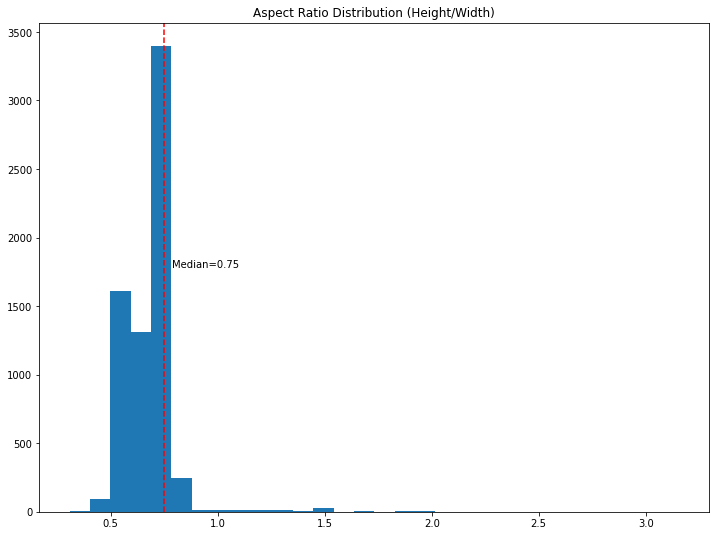

In [ ]:
ar=df.height/df.width

# Plot aspect ratio
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 9, forward=True)

plt.hist(ar, bins=30)
ax.axvline(ar.median(), color='red',linestyle='--')
plt.text(ar.median()*1.05, .5, f'Median={ar.median()}', transform=ax.get_xaxis_transform())
plt.title("Aspect Ratio Distribution (Height/Width)")

## How many classes have no viewpoint annotation?

In [ ]:
# df=df.dropna(subset=["viewpoint"], axis=0)
df['viewpoint']=df['viewpoint'].fillna("none")

In [ ]:
dfDetVP=df[df.viewpoint=="none"]
df=df[df.viewpoint!="none"]

In [ ]:
df["id"].count()

6647

In [ ]:
# images without viewpoint annotation
6795-6647

148

In [ ]:
gb=df.groupby(["name"])


In [ ]:
len(gb.groups)

430

# How many classes have only one image?

In [ ]:
OOD=[]
diverse=[]
nonDiverse=[]
vpsDist=[]
for val in gb.groups:
  vps=gb.get_group(val)['viewpoint'].unique()
  vpsDist.append(len(vps))
  if len(vps)==1:
    OOD.append(val)
  elif len(vps)>1 and len(vps)<4:
    nonDiverse.append(val)
  else:
    diverse.append(val)

In [ ]:
limVps=list(filter(lambda v: v != 1, vpsDist))

Text(0.5, 1.0, 'Viewpoint Distribution')

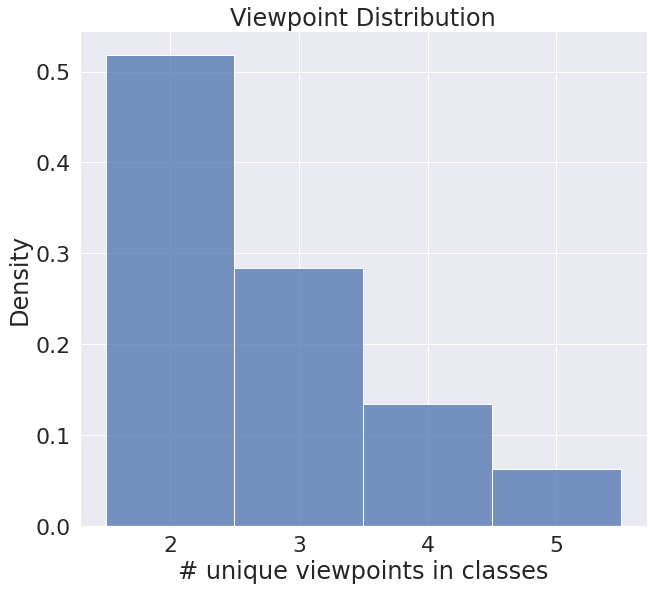

In [ ]:
sns.set(font_scale=2)
sns.displot(limVps, discrete=True, stat="density",
            height=8, aspect=1.2
            )
plt.xlabel("# unique viewpoints in classes")
plt.title("Viewpoint Distribution")

In [ ]:
vp2=round(334*.52)
vp3=round(334*.28)
vp4=round(334*.13)
vp5=round(334*.07)

print(vp2+vp3+vp4+vp5)

print(f"2 Viewpoint: {vp2}")
print(f"3 Viewpoint: {vp3}")
print(f"4 Viewpoint: {vp4}")
print(f"5 Viewpoint: {vp5}")

334
2 Viewpoint: 174
3 Viewpoint: 94
4 Viewpoint: 43
5 Viewpoint: 23


In [ ]:
df.loc[df.name.isin(nonDiverse)]

,bbox,viewpoint,segmentation,segmentation_bbox,area,id,image_id,uuid_x,individual_ids,name,file_name,photographer,coco_url,height,width,date_captured,gps_lat_captured,gps_lon_captured,flickr_url,uuid_y
59,"[59.64912280701754, 17.543859649122805, 2282.4...",left,"[[60, 18, 2342, 18, 2342, 1046, 60, 1046, 60, ...","[60, 18, 2282, 1028]",2345896,60,60,0c2f737a-7e8b-457a-ab74-bfbed3080bfc,"[60, 2508, 2515, 2516]",b29befd8-9bbb-4306-aacc-01ed8573810a,000000000060.jpg,,None,1192.0,2400.0,None,None,None,None,e594e724-29a2-9806-3c34-187b991f0579
129,"[382.8, 810.0, 1314.8000000000002, 594.0]",left,"[[383, 810, 1698, 810, 1698, 1404, 383, 1404, ...","[383, 810, 1315, 594]",781110,130,130,1256e818-c05e-493a-a6b4-f46e6fd12980,"[130, 131, 132, 133, 134, 135, 136, 137, 138, ...",ad886592-f2e1-4a83-84dd-aa9ca3b8763c,000000000130.jpg,,None,1600.0,2400.0,None,None,None,None,2f2021c8-922d-afe2-cbce-fc566b18d71d
130,"[1171.6000000000001, 913.6, 756.4000000000001,...",back,"[[1172, 914, 1928, 914, 1928, 1491, 1172, 1491...","[1172, 914, 756, 577]",436212,131,131,6035d1ae-225f-4c6a-a348-4e75ec9853e1,"[130, 131, 132, 133, 134, 135, 136, 137, 138, ...",ad886592-f2e1-4a83-84dd-aa9ca3b8763c,000000000131.jpg,,None,1600.0,2400.0,None,None,None,None,3aa2f8c4-0df9-3887-77ee-62161fa0f092
131,"[1148.8, 681.6, 792.0, 494.0]",back,"[[1149, 682, 1941, 682, 1941, 1176, 1149, 1176...","[1149, 682, 792, 494]",391248,132,132,b430d54a-c92f-485e-8e07-010acefc161d,"[130, 131, 132, 133, 134, 135, 136, 137, 138, ...",ad886592-f2e1-4a83-84dd-aa9ca3b8763c,000000000132.jpg,,None,1600.0,2400.0,None,None,None,None,815faa49-1ff2-4932-7d94-c53a40933069
132,"[1126.4, 475.20000000000005, 262.0, 616.0]",back,"[[1126, 475, 1388, 475, 1388, 1091, 1126, 1091...","[1126, 475, 262, 616]",161392,133,133,d4dd78b1-6c08-4a96-af44-95e8c35b8fe2,"[130, 131, 132, 133, 134, 135, 136, 137, 138, ...",ad886592-f2e1-4a83-84dd-aa9ca3b8763c,000000000133.jpg,,None,1600.0,2400.0,None,None,None,None,25d2aea1-aee4-5bbc-15c7-078e6807273e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6805,"[1107.8125, 724.4791666666667, 946.35416666666...",back,"[[1108, 724, 2054, 724, 2054, 1204, 1108, 1204...","[1108, 724, 946, 480]",454080,6806,6776,058adffb-b231-4661-9a63-b3cb657754ba,"[6788, 6792, 6806, 6811, 6821, 2468]",4f583226-f799-4639-8041-adc3731bb4b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6810,"[719.2708333333334, 892.7083333333334, 967.187...",front,"[[719, 893, 1686, 893, 1686, 1640, 719, 1640, ...","[719, 893, 967, 747]",722349,6811,6781,9e5e5c93-48c7-46d7-89ea-11982d4d2173,"[6788, 6792, 6806, 6811, 6821, 2468]",4f583226-f799-4639-8041-adc3731bb4b5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6812,"[992.1296296296297, 661.5740740740741, 879.629...",left,"[[992, 662, 1872, 662, 1872, 1161, 992, 1161, ...","[992, 662, 880, 499]",439120,6813,6783,19f2dc5c-01b6-431c-bfff-0542fa01ba13,"[6790, 6796, 6797, 6804, 6813, 6815]",3e7c7443-f123-4181-aeb2-3668d36211b8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6814,"[750.4629629629629, 555.5555555555555, 1198.61...",left,"[[750, 556, 1949, 556, 1949, 1177, 750, 1177, ...","[750, 556, 1199, 621]",744579,6815,6785,3debe023-0116-449b-8973-bf1a3e43cfbc,"[6790, 6796, 6797, 6804, 6813, 6815]",3e7c7443-f123-4181-aeb2-3668d36211b8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
round(len(df)*1.2)

7976

# Fifty one dataset
Let's create a dataset on fifty one using the coco format (original)

In [ ]:
# The directory containing the source images
data_path = "/mydrive/MIDS/W210/leopard.coco/images/train2022/"

# The path to the COCO labels JSON file
labels_path = "/mydrive/MIDS/W210/leopard.coco/annotations/instances_train2022.json"

# The path of train, test splits
output_path="/mydrive/MIDS/W210/Animal_Identification/datasets/leopard"


In [ ]:
# Import the dataset
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path=data_path,
    labels_path=labels_path,
)

 100% |███████████████| 6795/6795 [20.3s elapsed, 0s remaining, 379.4 samples/s]      


In [ ]:
# dataset.first()

# Split Dev-Test
Run the following cell to split test and dev folders.

In [ ]:
# split_dev_test(dataPath='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard')

In [ ]:
dev_images_path='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/images'
dev_labels_path='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/dev/labels'

train_images_path='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/train/images'
train_labels_path='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/train/labels'

# Check the number of negative samples needed
num_sample_dev=len(os.listdir(dev_images_path))
num_sample_train=len(os.listdir(train_images_path))
neg_sample_split=0.20

total_samples= num_sample_dev + num_sample_train
num_neg_samples = round(total_samples*neg_sample_split)
print(f"Negative samples that will be added: {num_neg_samples}")


Negative samples that will be added: 1221


In [ ]:
hyena_img_path='/content/hyena.coco/images/train2022'
giraffe_img_path='/content/gzgc.coco/images/train2020'

In [ ]:
clean_hyena=[i for i in os.listdir(hyena_img_path) if "_" not in i]
# clean_hyena

In [ ]:
# Check the number of samples in the hyena dataset
num_sample_hyena=len(clean_hyena)
if (2*num_neg_samples/3)>num_sample_hyena:
  print("There are not enough samples from hyena dataset")
else:
  print("Enough hyena samples")
  print(f"There are {num_sample_hyena} out of {(2*num_neg_samples/3)} required.")


Enough hyena samples
There are 3104 out of 814.0 required.


In [ ]:
f = open("/content/gzgc.coco/annotations/instances_train2020.json")

data = json.load(f)

In [ ]:
data['annotations'][167]

{'area': 1785408,
 'bbox': [1088.235294117647,
  449.75490196078437,
  1088.235294117647,
  1640.9313725490197],
 'category_id': 0,
 'id': 168,
 'image_id': 151,
 'individual_ids': [2661,
  2662,
  2695,
  6805,
  2663,
  168,
  4280,
  3671,
  3733,
  3731,
  3728,
  3670,
  3669,
  3729,
  3734],
 'iscrowd': 0,
 'isinterest': 0,
 'name': 'NNP_GIRM_0019',
 'review_ids': [],
 'segmentation': [[1088, 450, 2176, 450, 2176, 2091, 1088, 2091, 1088, 450]],
 'segmentation_bbox': [1088, 450, 1088, 1641],
 'theta': 0.0,
 'uuid': '47313643-e353-428d-a20e-89841c2932c7',
 'viewpoint': 'left'}

In [ ]:
data['images'][167]

{'coco_url': None,
 'date_captured': '2015-03-01 17:31:12',
 'file_name': '000000000168.jpg',
 'flickr_url': None,
 'gps_lat_captured': '-1.386391',
 'gps_lon_captured': '36.895941',
 'height': 2250,
 'id': 168,
 'license': 3,
 'photographer': "NNP GZC Car '12WHITE', Person 'A', Image 0062",
 'uuid': '1b1cc493-9cf3-7053-ef14-2c4615ca9d47',
 'width': 3000}

In [ ]:
giraffes=[]

# Check the number of samples in the giraffe dataset
num_sample_giraffe=len(os.listdir(giraffe_img_path))

for record in range(num_sample_giraffe):
  if data['annotations'][record]['category_id'] == 0:
    giraffes.append(data['images'][record]['file_name'])

if (num_neg_samples/3)>len(giraffes):
  print("There are not enough samples from giraffe")
  print(f"{len(giraffes)} out of {num_neg_samples/3} required")
else:
  print("Enough giraffe samples")
  print(f"There are {len(giraffes)} out of {num_neg_samples/3} required.")


  

Enough giraffe samples
There are 455 out of 407.0 required.


In [ ]:
neg_annotations=[]
neg_images=[]

In [ ]:

np.random.seed(42)
neg_sample_count=0

# Shuffle the hyena images
np.random.shuffle(clean_hyena)
np.random.shuffle(giraffes)

# Take a sample until we collect the num of neg samples
for s in range(num_neg_samples):
  first_split = np.random.random_sample()
  second_split = np.random.random_sample()
  
  # Check if the images will be moved to train or dev set
  if first_split <0.8:

    # Check if the image has to be hyena or giraffe
    # hyena < 0.5
    if second_split <0.66:
      suffix='/hyena_'
      # Select the image
      img=clean_hyena.pop(0)
      # Create new name
      new_filename=suffix+img
      # Locate image
      source=hyena_img_path+'/'+img
      labelPath=train_labels_path+suffix+img[:-3]+'txt'
      
    else:
      suffix='/giraffe_'
      img=giraffes.pop(0)
      new_filename=suffix+img
      source=giraffe_img_path+'/'+img
    
    labelPath=train_labels_path+suffix+img[:-3]+'txt'
      

    # Send to train dataset
    destination=train_images_path+new_filename
  else:
    if second_split <0.66:
      suffix='/hyena_'
      # Select the image
      img=clean_hyena.pop(0)
      # Create new name
      new_filename=suffix+img
      # Locate image
      source=hyena_img_path+'/'+img
      labelPath=dev_labels_path+suffix+img[:-3]+'txt'
      
    else:
      suffix='/giraffe_'
      img=giraffes.pop(0)
      new_filename=suffix+img
      source=giraffe_img_path+'/'+img
    
    labelPath=dev_labels_path+suffix+img[:-3]+'txt'
    # Send to dev dataset
    destination=dev_images_path+new_filename

  # Collect all annotations and images on a list 
  neg_annotations.append(labelPath)
  neg_images.append(destination)

  # Move them baed on the source and destination
  shutil.move(source,destination)
  # create empty text files
  with open(labelPath, 'w'): pass

# print(neg_annotations)
# print(neg_images)






In [ ]:
# Write a reference file for images and annotations
with open('/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/neg_annotations.txt','w') as na:
  for item in neg_annotations:
    na.write(item+"\n")
  
with open('/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/neg_images.txt','w') as ni:
  for item in neg_images:
    ni.write(item+"\n")

In [ ]:
len(clean_hyena)

2304

In [ ]:
len(neg_annotations) == num_neg_samples

True

In [ ]:
!tar -xzvf "/content/gdrive/MyDrive/MIDS/W210/hyena.coco.tar.gz" -C "/content"     #[run this cell to extract tar.gz files]

Streaming output truncated to the last 5000 lines.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
hyena.coco/images/train2022/000000000715.jpg
hyena.coco/images/train2022/._000000002102.jpg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
hyena.coco/images/train2022/000000002102.jpg
hyena.coco/images/train2022/._000000002116.jpg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
hyena.coco/images/train2022/000000002116.jpg
hyena.coco/images/train2022/._000000000701.jpg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
hyena.coco/images/train2022/000000000701.jpg
hyena.coco/images/train2022/._000000001379.jpg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
hyena.coco/images/train2022/000000001379.jpg
hyena.coco/images/train2022/._000000000067.jpg
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.x

In [ ]:
!tar -xzvf "/content/gdrive/MyDrive/MIDS/W210/gzgc.coco.tar.gz" -C "/content"     #[run this cell to extract tar.gz files]

gzgc.coco/
gzgc.coco/images/
gzgc.coco/images/test2020/
gzgc.coco/images/train2020/
gzgc.coco/images/train2020/000000004944.jpg
gzgc.coco/images/train2020/000000003668.jpg
gzgc.coco/images/train2020/000000001984.jpg
gzgc.coco/images/train2020/000000002797.jpg
gzgc.coco/images/train2020/000000001510.jpg
gzgc.coco/images/train2020/000000001736.jpg
gzgc.coco/images/train2020/000000000376.jpg
gzgc.coco/images/train2020/000000004204.jpg
gzgc.coco/images/train2020/000000000203.jpg
gzgc.coco/images/train2020/000000002177.jpg
gzgc.coco/images/train2020/000000001871.jpg
gzgc.coco/images/train2020/000000004711.jpg
gzgc.coco/images/train2020/000000000977.jpg
gzgc.coco/images/train2020/000000002484.jpg
gzgc.coco/images/train2020/000000004188.jpg
gzgc.coco/images/train2020/000000003681.jpg
gzgc.coco/images/train2020/000000000481.jpg
gzgc.coco/images/train2020/000000001240.jpg
gzgc.coco/images/train2020/000000004685.jpg
gzgc.coco/images/train2020/000000001720.jpg
gzgc.coco/images/train2020/000000000

# Delete files moved to the train set

1. Load annotations
2. Delete the file

In [ ]:
filePath='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/neg_images.txt'
with open(filePath, 'r') as f:
  lines=f.readlines()

In [ ]:
for line in lines:
  os.remove(line[:-1])

In [ ]:
filePath='/content/gdrive/MyDrive/MIDS/W210/Animal_Identification/datasets/leopard/neg_annotations.txt'
with open(filePath, 'r') as f:
  lines=f.readlines()

In [ ]:
for line in lines:
  os.remove(line[:-1])

In [ ]:
# Run Fifty One session
session = fo.launch_app(dataset)

## end